In [1]:
%matplotlib inline
import os
import tqdm
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import glob
import json 
import plotnine as pn
import matplotlib.pyplot as plt
import collections
from tcre.env import *
from tcre.supervision import get_candidate_classes, SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_MAP
from tcre.exec.v1 import optim
from tcre.modeling import features
from tcre.modeling import sampling
from snorkel.learning.utils import LabelBalancer
from snorkel import SnorkelSession
from snorkel.models import Candidate
import logging
session = SnorkelSession()
%run ../src/tcre/logging.py
classes = get_candidate_classes()

/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-strong', 'run1')
#output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-strong', 'run2')
#output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-strong', 'run3')
output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-rnn-strong', 'run4') # last annotation round
output_dir

'/lab/data/results/modeling-rnn-strong/run4'

In [3]:
tasks = [classes[c].field for c in classes]
tasks

['inducing_cytokine', 'secreted_cytokine', 'inducing_transcription_factor']

### Initialize Optimizers

In [4]:
from skopt.space import Categorical
from skopt.space import Space

space = Space([
    Categorical(['doub_01'], name='marker_list'),
    Categorical([True, False], name='use_secondary'),
    Categorical([True], name='use_swaps'),
    Categorical([True], name='use_positions'),
    Categorical(['w2v_frozen', 'w2v_trained'], name='wrd_embedding_type'),
    Categorical(['XL', 'XXL', 'XXXL', 'XXXXL'], name='model_size'),
    Categorical([0.0, .0001, .001, .005], name='weight_decay'),
    Categorical([.005, .01, .05], name='learning_rate'),
    Categorical([0.0, 0.25, 0.5, 0.75], name='dropout'),
    Categorical(['LSTM'], name='cell_type'),
    Categorical([False], name='bidirectional')
])

In [5]:
n_space = np.prod([len(dim.categories) for dim in space])
print('Number of combinations in parameter space:', n_space)

Number of combinations in parameter space: 768


In [6]:
space.rvs()[0]

['doub_01',
 False,
 True,
 True,
 'w2v_trained',
 'XXL',
 0.001,
 0.01,
 0.25,
 'LSTM',
 False]

In [7]:
from skopt import forest_minimize, dummy_minimize

optimizers = {
    task: optim.TaskParameterOptimizer(
        task, space, output_dir, minimizer=dummy_minimize, client_args=dict(cli={'batch_size': 512})
    ) for task in tasks
}

In [8]:
optimizers[tasks[0]].client.exceptions

['log_level',
 'seed',
 'vocab_limit',
 'use_lower',
 'save_keys',
 'log_iter_interval',
 'log_epoch_interval',
 'balance',
 'batch_size',
 'simulation_strategy',
 'swap_list']

### Create Splits for Tasks

In [9]:
# DB splits -> modeling splits 
TARGET_MAP = {'dev': 'train', 'val': 'val', 'test': 'test'}
df_cand, df_dist = sampling.get_modeling_splits(session, target_split_map=TARGET_MAP)

# Duplicate val candidates for prediction
df_cand = pd.concat([
    df_cand, df_cand[df_cand['split'] == 'val'].assign(split='predict')
])

# Write splits to file
for task, g in df_cand.groupby('task'):
    splits = g.groupby('split')['id'].unique()
    splits_file = optimizers[task].write_splits(splits)
    print(f'Splits for task {task} written to "{splits_file}"')
df_dist

Splits for task inducing_cytokine written to "/lab/data/results/modeling-rnn-strong/run4/inducing_cytokine/splits/splits.json"
Splits for task inducing_transcription_factor written to "/lab/data/results/modeling-rnn-strong/run4/inducing_transcription_factor/splits/splits.json"
Splits for task secreted_cytokine written to "/lab/data/results/modeling-rnn-strong/run4/secreted_cytokine/splits/splits.json"


statistic                           percent       count     
label                                     0     1     0    1
task                          split                         
inducing_cytokine             test     50.0  50.0    29   29
                              train    50.0  50.0   145  145
                              val      50.0  50.0    23   23
inducing_transcription_factor test     50.0  50.0    58   58
                              train    50.0  50.0   107  107
                              val      50.0  50.0    44   44
secreted_cytokine             test     50.0  50.0    64   64
                              train    50.0  50.0   131  131
                              val      50.0  50.0    49   49

In [10]:
df_cand.groupby(['task', 'split']).size().unstack()

split,predict,test,train,val
task,,,,
inducing_cytokine,46,58,290,46
inducing_transcription_factor,88,116,214,88
secreted_cytokine,98,128,262,98


### Run Search

In [11]:
# Show an example command to be run 
print(optimizers[tasks[0]].get_cmd(space.rvs()[0]))

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=inducing_cytokine --device="cuda:1" --output-dir=/lab/data/results/modeling-rnn-strong/run4/inducing_cytokine/data --batch-size=512 train --splits-file=/lab/data/results/modeling-rnn-strong/run4/inducing_cytokine/splits/splits.json --use-checkpoints=False --save-keys="history" --marker-list=doub_01 --use-secondary=False --use-swaps=True --use-positions=True --wrd-embedding-type=w2v_trained --model-size=XXXL --weight-decay=0.001 --learning-rate=0.05 --dropout=0.75 --cell-type=LSTM --bidirectional=False > /lab/data/results/modeling-rnn-strong/run4/inducing_cytokine/log/log.txt 2>&1


In [12]:
# For 3 tasks at about about 30s per iteration, show common time estimations:
time_per_iter_sec = 30
n_iter = np.array([10, 100, 250, 500, 1000])
for n in n_iter:
    time = n * time_per_iter_sec * len(tasks) / 3600
    print(f'Iterations = {n} --> Time = {time} (hrs)')

Iterations = 10 --> Time = 0.25 (hrs)
Iterations = 100 --> Time = 2.5 (hrs)
Iterations = 250 --> Time = 6.25 (hrs)
Iterations = 500 --> Time = 12.5 (hrs)
Iterations = 1000 --> Time = 25.0 (hrs)


In [13]:
results = {}

for task in tasks:
    optimizer = optimizers[task]
    logging.info(f'Running optimization for task {task}')
    # kappa=3.090 -> 99.8% confidence interval (favors exploration when higher than default 1.96)
    #res, scores, callbacks = optimizer.run(n_iterations=250, progress_interval=1, checkpoint_interval=10, n_random_starts=10, acq_func='LCB', kappa=3.090)
    res, scores, callbacks = optimizer.run(n_iterations=64, progress_interval=1, checkpoint_interval=10)
    
    # Save scores for non-objective (i.e. validation) after converting to long form
    scores = pd.DataFrame(scores)
    scores.columns = pd.MultiIndex.from_tuples([c for c in scores])
    scores = scores.rename_axis('iteration', axis=0).rename_axis(('metric', 'type'), axis=1)
    scores = scores.stack().stack().rename('value').reset_index()
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    scores.to_feather(scores_file)
    logging.info(f'Saved scores to {scores_file}')
    
    # Checkpoint final result since it is not saved at every step
    callbacks['saver'].i = -1
    callbacks['saver'](res)
    logging.info(f'Saved final result')
    
    results[task] = res, scores, callbacks

2019-09-11 14:44:12,311:INFO:root: Running optimization for task inducing_cytokine
2019-09-11 14:44:12,313:INFO:tcre.exec.v1.optim: Beginning parameter search with max iterations 64
2019-09-11 14:44:31,218:INFO:tcre.exec.v1.optim: Completed iteration 1 of 64 (score = -0.693877551020408)
2019-09-11 14:44:52,089:INFO:tcre.exec.v1.optim: Completed iteration 2 of 64 (score = -0.6551724137931031)
2019-09-11 14:45:08,273:INFO:tcre.exec.v1.optim: Completed iteration 3 of 64 (score = -0.5862068965517241)
2019-09-11 14:45:26,315:INFO:tcre.exec.v1.optim: Completed iteration 4 of 64 (score = -0.68)
2019-09-11 14:45:45,051:INFO:tcre.exec.v1.optim: Completed iteration 5 of 64 (score = -0.711111111111111)
2019-09-11 14:46:01,946:INFO:tcre.exec.v1.optim: Completed iteration 6 of 64 (score = -0.678571428571428)
2019-09-11 14:46:17,661:INFO:tcre.exec.v1.optim: Completed iteration 7 of 64 (score = -0.6567164179104471)
2019-09-11 14:46:34,485:INFO:tcre.exec.v1.optim: Completed iteration 8 of 64 (score = 

In [14]:
print(tasks[0])
res, scores, callbacks = results[tasks[0]]

inducing_cytokine


In [15]:
times = callbacks['timer'].iter_time
pd.Series(times).describe()

count    64.000000
mean     18.179572
std       2.455694
min      15.235013
25%      16.682267
50%      17.352708
75%      19.286967
max      28.460095
dtype: float64

In [16]:
res.func_vals[:5]

array([-0.69387755, -0.65517241, -0.5862069 , -0.68      , -0.71111111])

In [17]:
pd.DataFrame(res.x_iters[:5], columns=[dim.name for dim in space])

,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional
0,doub_01,True,True,True,w2v_trained,XXXL,0.000,0.010,0.75,LSTM,False
1,doub_01,False,True,True,w2v_trained,XXXL,0.005,0.050,0.25,LSTM,False
2,doub_01,False,True,True,w2v_frozen,XXXXL,0.005,0.010,0.00,LSTM,False
3,doub_01,False,True,True,w2v_trained,XL,0.005,0.005,0.75,LSTM,False
4,doub_01,True,True,True,w2v_trained,XXXXL,0.001,0.005,0.00,LSTM,False


In [18]:
res.models[:5]

[]

## Analysis

In [19]:
output_dir

'/lab/data/results/modeling-rnn-strong/run4'

In [20]:
!ls $output_dir

inducing_cytokine  inducing_transcription_factor  secreted_cytokine


In [21]:
import skopt
# Restore from serialized data

results = {}
for task in tasks:
    optimizer = optimizers[task]
    res = skopt.load(optimizer.get_checkpoints_file())
    
    scores = None
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    if osp.exists(scores_file):
        scores = pd.read_feather(scores_file)
    
    results[task] = res, scores, globals().get('times') 

In [22]:
def get_dfx(results):
    df = []
    for k in results:
        res = results[k][0]
        dfx = pd.DataFrame(res.x_iters, columns=[dim.name for dim in space])
        dfx['score'] = -res.func_vals
        dfx['task'] = k
        dfx['iteration'] = np.arange(len(dfx))
        df.append(dfx)
    return pd.concat(df)

In [23]:
dfx = get_dfx(results)
props = dfx.drop(['score', 'task', 'iteration'], axis=1).columns.tolist()
print(props)
dfx.head()

['marker_list', 'use_secondary', 'use_swaps', 'use_positions', 'wrd_embedding_type', 'model_size', 'weight_decay', 'learning_rate', 'dropout', 'cell_type', 'bidirectional']


,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional,score,task,iteration
0,doub_01,True,True,True,w2v_trained,XXXL,0.000,0.010,0.75,LSTM,False,0.693878,inducing_cytokine,0
1,doub_01,False,True,True,w2v_trained,XXXL,0.005,0.050,0.25,LSTM,False,0.655172,inducing_cytokine,1
2,doub_01,False,True,True,w2v_frozen,XXXXL,0.005,0.010,0.00,LSTM,False,0.586207,inducing_cytokine,2
3,doub_01,False,True,True,w2v_trained,XL,0.005,0.005,0.75,LSTM,False,0.680000,inducing_cytokine,3
4,doub_01,True,True,True,w2v_trained,XXXXL,0.001,0.005,0.00,LSTM,False,0.711111,inducing_cytokine,4


In [24]:
# Show top configs by task
pd.set_option('display.max_rows', 100)
dfx.groupby('task').apply(lambda g: g.sort_values('score', ascending=False).iloc[:8].reset_index(drop=True)).style.background_gradient()

### Parameter Regression

In [25]:
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='The default of the `iid` parameter.*')

def get_coefs(est):
    coefs = []
    grps = dfx.groupby(['task'])
    fig, axs = plt.subplots(1, len(grps))
    if len(grps) == 1:
        axs = [axs]
    fig.set_size_inches(18, 4)
    for i, (k, g) in enumerate(grps):
        X = pd.get_dummies(g.drop(['task', 'iteration', 'score'], axis=1).astype(str), prefix_sep=':')
        y = g['score'].values
        est = est.fit(X.values, y)
        y_pred = est.predict(X)
        score = max(r2_score(y, y_pred), 0)
        title = f'{est.__class__.__name__} {k} (R2={score:.2f})'
        pd.DataFrame({'y_true': y, 'y_pred': y_pred}).plot(kind='scatter', x='y_pred', y='y_true', ax=axs[i], title=title)
        coefs.append(
            pd.Series(est.coef_, index=X.columns.to_list()).sort_index()
            .append(pd.Series(dict(task=k, score=score, est=est.__class__.__name__)))
        )
    return est, pd.DataFrame(coefs)

def plot_coefs(est, coefs):
    return (
        pn.ggplot(
            coefs
                .set_index('task').rename_axis('metric', axis='columns').stack().rename('value').reset_index()
                .assign(metric=lambda df: pd.Categorical(df['metric'], ordered=True, categories=df.groupby('metric')['value'].mean().sort_values().index)), 
            pn.aes(x='metric', y='value', fill='task', color='task', group='task')
        ) + 
        pn.geom_point() +
        pn.geom_line() + 
        pn.ggtitle(type(est).__name__) + 
        pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=90, hjust=.5))
    )

In [26]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

bidirectional:False  \
task                          score    est          weight                          
inducing_cytokine             0.731422 RidgeCV      0.335253                  0.0   
                              0.724958 LassoCV      0.332290                  0.0   
                              0.725322 ElasticNetCV 0.332457                  0.0   
inducing_transcription_factor 0.280064 RidgeCV      0.351183                  0.0   
                              0.259473 LassoCV      0.325364                  0.0   

                                                              cell_type:LSTM  \
task                          score    est          weight                     
inducing_cytokine             0.731422 RidgeCV      0.335253             0.0   
                              0.724958 LassoCV      0.332290             0.0   
                              0.725322 ElasticNetCV 0.332457             0.0   
inducing_transcription_factor 0.280064 RidgeCV      0.351183             0.0   
                              0.259473 LassoCV      0.325364             0.0   

                                                              dropout:0.0  \
task                          score    est          weight                  
inducing_cytokine             0.731422 RidgeCV      0.335253    -0.007491   
                              0.724958 LassoCV      0.332290    -0.009909   
                              0.725322 ElasticNetCV 0.332457    -0.010040   
inducing_transcription_factor 0.280064 RidgeCV      0.351183    -0.000290   
                              0.259473 LassoCV      0.325364     0.000000   

                                                              dropout:0.25  \
task                          score    est          weight                   
inducing_cytokine             0.731422 RidgeCV      0.335253     -0.010061   
                              0.724958 LassoCV      0.332290     -0.012520   
                              0.725322 ElasticNetCV 0.332457     -0.012567   
inducing_transcription_factor 0.280064 RidgeCV      0.351183     -0.002300   
                              0.259473 LassoCV      0.325364     -0.000000   

                                                              dropout:0.5  \
task                          score    est          weight                  
inducing_cytokine             0.731422 RidgeCV      0.335253     0.006913   
                              0.724958 LassoCV      0.332290     0.000000   
                              0.725322 ElasticNetCV 0.332457     0.000000   
inducing_transcription_factor 0.280064 RidgeCV      0.351183    -0.001059   
                              0.259473 LassoCV      0.325364    -0.000000   

                                                              dropout:0.75  \
task                          score    est          weight                   
inducing_cytokine             0.731422 RidgeCV      0.335253      0.007509   
                              0.724958 LassoCV      0.332290      0.001321   
                              0.725322 ElasticNetCV 0.332457      0.001395   
inducing_transcription_factor 0.280064 RidgeCV      0.351183      0.003591   
                              0.259473 LassoCV      0.325364      0.005164   

                                                              learning_rate:0.005  \
task                          score    est          weight                          
inducing_cytokine             0.731422 RidgeCV      0.335253            -0.017022   
                              0.724958 LassoCV      0.332290            -0.016036   
                              0.725322 ElasticNetCV 0.332457            -0.016016   
inducing_transcription_factor 0.280064 RidgeCV      0.351183            -0.000522   
                              0.259473 LassoCV      0.325364            -0.000000   

                                                              learning_rate:0.01  \
task                          score    est         

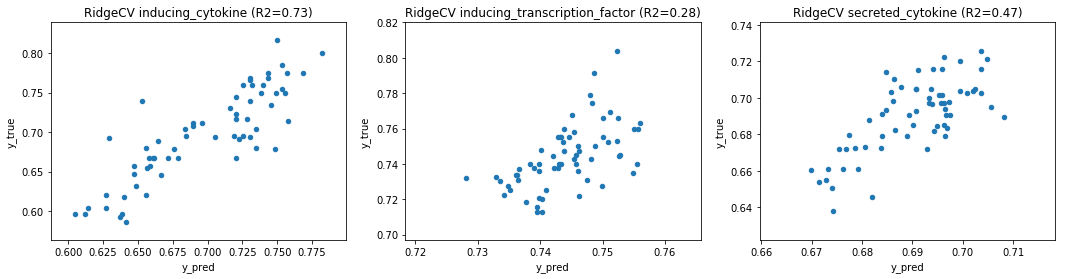

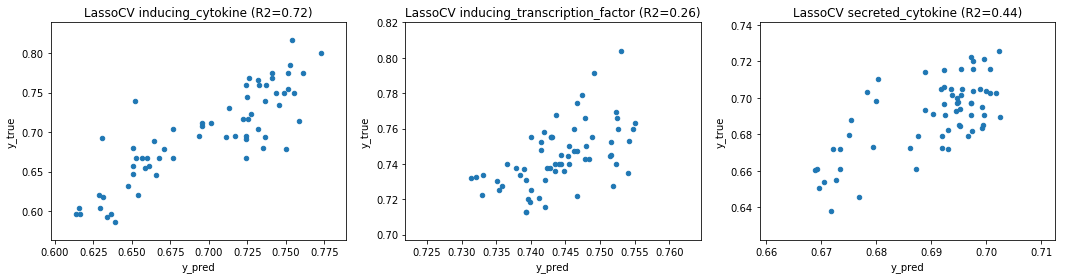

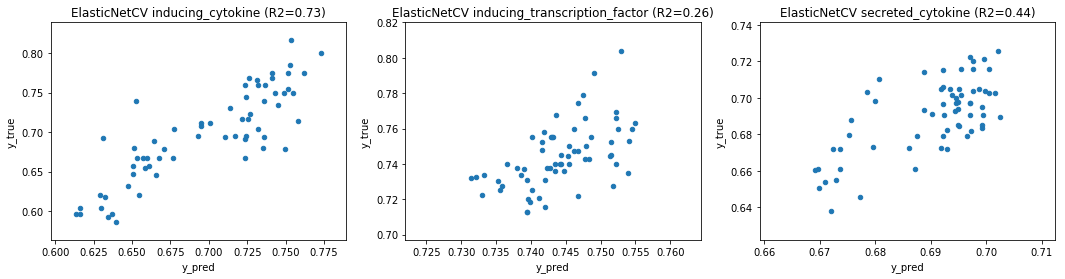

In [27]:
df_coef = pd.concat([
    get_coefs(RidgeCV(normalize=True, cv=5))[1],
    get_coefs(LassoCV(normalize=True, cv=5, random_state=1))[1],
    get_coefs(ElasticNetCV(normalize=True, cv=5, random_state=1))[1]
])

# Add weight for each model as R2 for model / R2 for all models
df_coef = df_coef.groupby('task', group_keys=False).apply(lambda g: g.assign(weight=(g['score'] / g['score'].sum())))
df_coef = df_coef.set_index(['task', 'score', 'est', 'weight'])

df_coef.head()

In [28]:
df_coef_lng = df_coef.rename_axis('parameter', axis='columns').stack().rename('value').reset_index()
df_coef_lng['weighted_value'] = df_coef_lng['value'] * df_coef_lng['weight']
df_coef_lng.head()

,task,score,est,weight,parameter,value,weighted_value
0,inducing_cytokine,0.731422,RidgeCV,0.335253,bidirectional:False,0.000000,0.000000
1,inducing_cytokine,0.731422,RidgeCV,0.335253,cell_type:LSTM,0.000000,0.000000
2,inducing_cytokine,0.731422,RidgeCV,0.335253,dropout:0.0,-0.007491,-0.002511
3,inducing_cytokine,0.731422,RidgeCV,0.335253,dropout:0.25,-0.010061,-0.003373
4,inducing_cytokine,0.731422,RidgeCV,0.335253,dropout:0.5,0.006913,0.002318


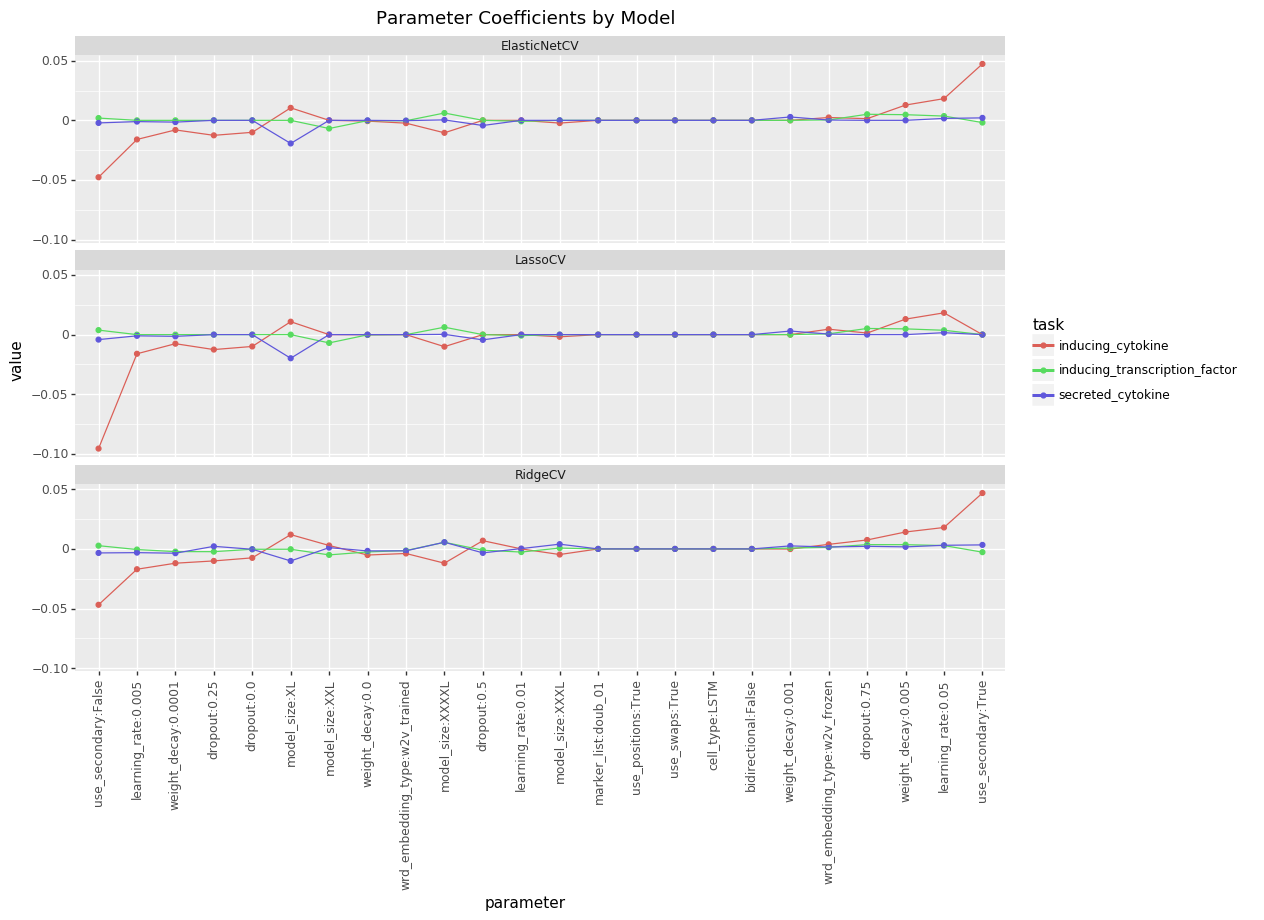

<ggplot: (-9223363307607869664)>

In [29]:
(
    pn.ggplot(
        df_coef_lng.assign(parameter=lambda df: pd.Categorical(
            df['parameter'], ordered=True, 
            categories=df.groupby('parameter')['weighted_value'].mean().sort_values().index
        )), 
        pn.aes(x='parameter', y='value', fill='task', color='task', group='task')
    ) + 
    pn.geom_point() +
    pn.geom_line() + 
    pn.ggtitle('Parameter Coefficients by Model') + 
    pn.facet_wrap('~ est', ncol=1) +
    pn.theme(figure_size=(12, 8), axis_text_x=pn.element_text(rotation=90, hjust=.5))
)

### Score Distributions

In [30]:
df_score = pd.concat([v[1].assign(task=k) for k, v in results.items()])
df_score.head()

,iteration,type,metric,value,task
0,0,,epoch,22.000000,inducing_cytokine
1,0,test,accuracy,0.500000,inducing_cytokine
2,0,test,ct,58.000000,inducing_cytokine
3,0,test,f1,0.524590,inducing_cytokine
4,0,test,loss,2.640673,inducing_cytokine


In [31]:
# Label balance
df_lbl = df_cand.assign(label=lambda df: np.where(df['label'] > 0, 1, 0))
pd.concat([
    df_lbl.assign(agg='count').groupby(['task', 'split', 'agg'])['label'].value_counts().unstack([-2, -1]),
    df_lbl.assign(agg='percent').groupby(['task', 'split', 'agg'])['label'].value_counts(normalize=True).unstack([-2, -1]).round(2)
], axis=1)

agg                                   count      percent     
label                                     0    1       0    1
task                          split                          
inducing_cytokine             predict    23   23     0.5  0.5
                              test       29   29     0.5  0.5
                              train     145  145     0.5  0.5
                              val        23   23     0.5  0.5
inducing_transcription_factor predict    44   44     0.5  0.5
                              test       58   58     0.5  0.5
                              train     107  107     0.5  0.5
                              val        44   44     0.5  0.5
secreted_cytokine             predict    49   49     0.5  0.5
                              test       64   64     0.5  0.5
                              train     131  131     0.5  0.5
                              val        49   49     0.5  0.5

In [32]:
(
    df_score
    .pivot_table(index=['task', 'iteration'], columns=['metric', 'type'], values='value')
    .head()[('epoch', '')]
)

task               iteration
inducing_cytokine  0            22.0
                   1            50.0
                   2             1.0
                   3            33.0
                   4            12.0
Name: (epoch, ), dtype: float64

In [33]:
df_score.head()

,iteration,type,metric,value,task
0,0,,epoch,22.000000,inducing_cytokine
1,0,test,accuracy,0.500000,inducing_cytokine
2,0,test,ct,58.000000,inducing_cytokine
3,0,test,f1,0.524590,inducing_cytokine
4,0,test,loss,2.640673,inducing_cytokine


In [34]:
df_top_score = (
    df_score
    # Pivot to task and hyperparameter config number (all scores already filtered to best epoch)
    .pivot_table(index=['task', 'iteration'], columns=['metric', 'type'], values='value')
    # Remove models with early top score
    .pipe(lambda df: df[df[('epoch', '')] >= 5])
    # Filter to best model config based on validation score
    .pipe(lambda df: df.groupby('task').apply(lambda g: g.iloc[np.argmax(g[('f1', 'validation')].values)]))
)
df_top_score.head()

metric                         accuracy                          ct           \
type                               test  training validation   test training   
task                                                                           
inducing_cytokine              0.568966  0.982759   0.804348   58.0    290.0   
inducing_transcription_factor  0.577586  0.691589   0.784091  116.0    214.0   
secreted_cytokine              0.578125  0.980916   0.683673  128.0    262.0   

metric                                   epoch        f1                       \
type                          validation            test  training validation   
task                                                                            
inducing_cytokine                   46.0  52.0  0.545455  0.982578   0.816327   
inducing_transcription_factor       88.0  35.0  0.614173  0.707965   0.804124   
secreted_cytokine                   98.0  15.0  0.614286  0.981132   0.725664   

metric                         ... precision@70 precision@80            \
type                           ...   validation         test  training   
task                           ...                                       
inducing_cytokine              ...     0.772727     0.619048  1.000000   
inducing_transcription_factor  ...     0.875000     0.000000  0.000000   
secreted_cytokine              ...     0.625000     0.472727  0.992126   

metric                                   precision@90                      \
type                          validation         test training validation   
task                                                                        
inducing_cytokine               0.722222      0.62500      1.0   0.769231   
inducing_transcription_factor   0.000000      0.00000      0.0   0.000000   
secreted_cytokine               0.608696      0.44898      1.0   0.625000   

metric                           recall                       
type                               test  training validation  
task                                                          
inducing_cytokine              0.517241  0.972414   0.869565  
inducing_transcription_factor  0.672414  0.747664   0.886364  
secreted_cytokine              0.671875  0.992366   0.836735  

[3 rows x 34 columns]

In [35]:
# Scores at best validation F1 iteration
def get_scores_table(metrics):
    df_bal = (
        df_lbl.assign(metric='balance').groupby(['task', 'metric', 'split'])['label'].value_counts(normalize=True)
        .unstack().round(2)[1].unstack([-2, -1])
    )
    return (
        df_top_score
        .round(2)
        .pipe(lambda df: pd.concat([df, df_bal], axis=1, sort=True))
        .style.background_gradient(cmap='Greens', low=.1, high=.3)
    )

In [36]:
# Scores at best validation F1 iteration
get_scores_table(['ct', 'f1', 'accuracy', 'precision', 'recall'])

In [37]:
# Median scores
p = (
    df_score
    .pipe(lambda df: df[df['metric'].isin(['precision', 'recall', 'f1'])])
    .groupby(['task', 'metric', 'type'])['value'].describe()[['mean', '25%', '50%', '75%']].unstack()['50%'].unstack()[['test', 'validation']]
    .round(3)
    .style.background_gradient(cmap='Greens', low=.3, high=.9)
)

In [38]:
p

/opt/conda/envs/nlp/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_ydensity : Removed 1 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


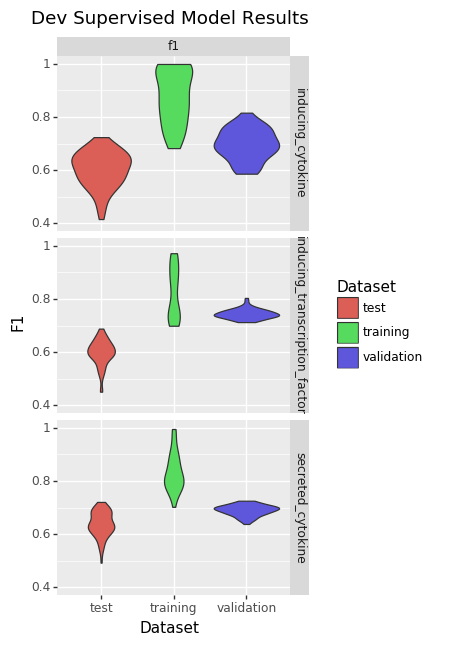

<ggplot: (8729247377058)>

In [39]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.ylim(.4, 1) +
    pn.labs(y='F1', title='Dev Supervised Model Results', x='Dataset', fill='Dataset') + 
    pn.facet_grid('task ~ metric', scales='free') + 
    pn.theme(figure_size=(3, 7))
)

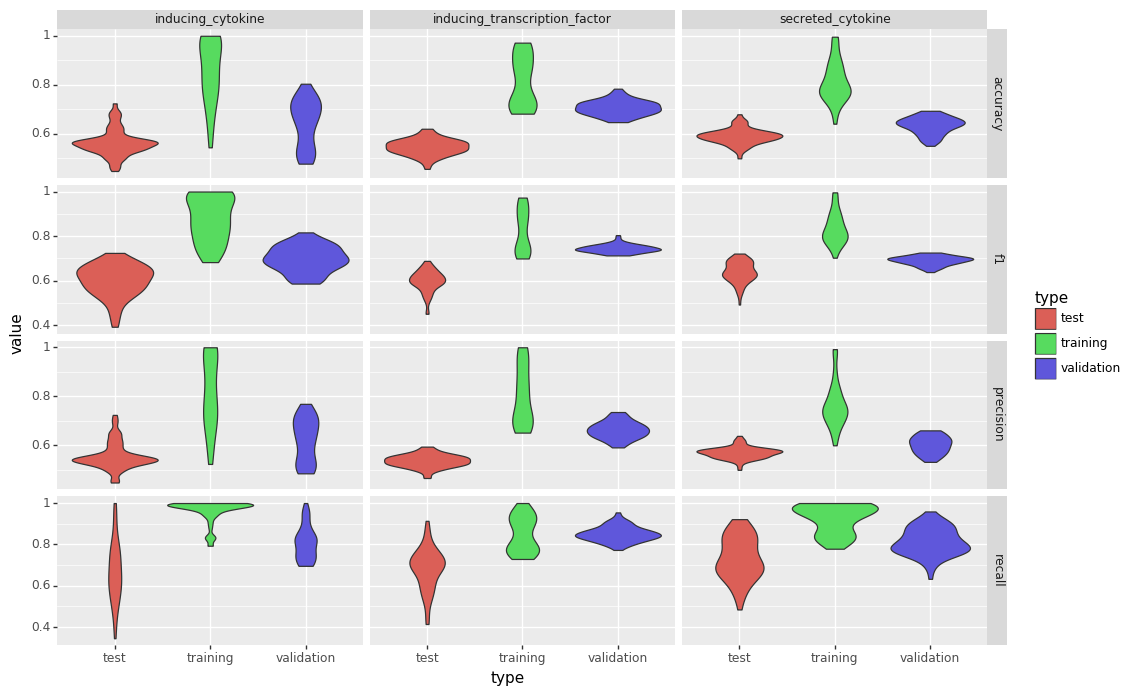

<ggplot: (8729247282124)>

In [40]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1', 'accuracy', 'precision', 'recall'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 8))
)

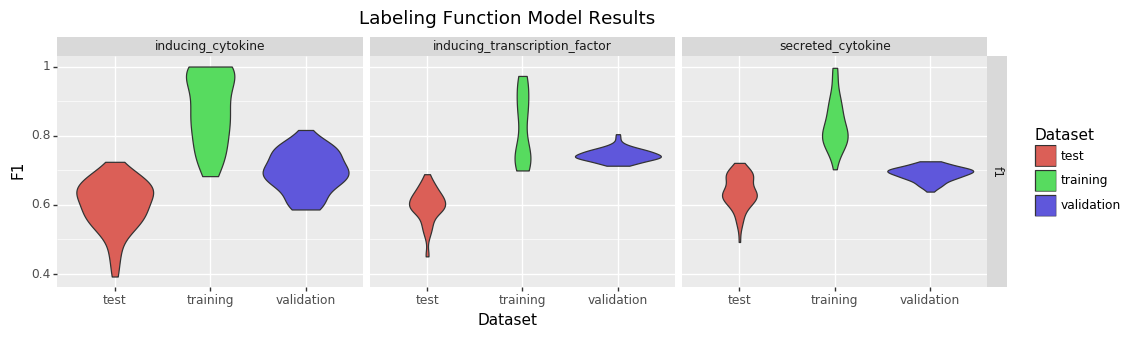

<ggplot: (8729247308969)>

In [41]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.labs(y='F1', title='Labeling Function Model Results', x='Dataset', fill='Dataset') + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 3))
)

## Export

Export scores:

In [42]:
df_exp = df_top_score.stack().stack().rename('value').reset_index().rename(columns={'type': 'split'}).assign(model='rnn-dev')
assert df_exp.groupby(['task', 'metric', 'split']).size().max() == 1
df_exp.head()

,task,split,metric,value,model
0,inducing_cytokine,,epoch,52.000000,rnn-dev
1,inducing_cytokine,test,accuracy,0.568966,rnn-dev
2,inducing_cytokine,test,ct,58.000000,rnn-dev
3,inducing_cytokine,test,f1,0.545455,rnn-dev
4,inducing_cytokine,test,loss,1.126029,rnn-dev


In [43]:
df_exp[df_exp['metric'] == 'epoch']['value'].value_counts()

15.0    1
35.0    1
52.0    1
Name: value, dtype: int64

In [44]:
path = osp.join(output_dir, 'scores.csv')
df_exp.to_csv(path, index=False)
path

'/lab/data/results/modeling-rnn-strong/run4/scores.csv'

Export top model configurations for each task:

In [45]:
# Show top 3 models
dftm = dfx.groupby('task', group_keys=False)\
    .apply(lambda g: g.sort_values('score', ascending=False).iloc[:3].reset_index(drop=True).assign(rank=lambda df: 1+np.arange(len(df))))\
    .reset_index(drop=True)\
    .rename(columns={dim.name: f'param:{dim.name}' for dim in space})
dftm

,param:marker_list,param:use_secondary,param:use_swaps,param:use_positions,param:wrd_embedding_type,param:model_size,param:weight_decay,param:learning_rate,param:dropout,param:cell_type,param:bidirectional,score,task,iteration,rank
0,doub_01,True,True,True,w2v_trained,XXXL,0.0050,0.050,0.25,LSTM,False,0.816327,inducing_cytokine,48,1
1,doub_01,True,True,True,w2v_frozen,XXL,0.0050,0.050,0.50,LSTM,False,0.800000,inducing_cytokine,55,2
2,doub_01,True,True,True,w2v_frozen,XXXXL,0.0050,0.050,0.00,LSTM,False,0.785714,inducing_cytokine,15,3
3,doub_01,False,True,True,w2v_trained,XL,0.0050,0.005,0.75,LSTM,False,0.804124,inducing_transcription_factor,3,1
4,doub_01,True,True,True,w2v_trained,XXXXL,0.0010,0.050,0.50,LSTM,False,0.791667,inducing_transcription_factor,57,2
5,doub_01,False,True,True,w2v_frozen,XL,0.0001,0.050,0.50,LSTM,False,0.778947,inducing_transcription_factor,63,3
6,doub_01,True,True,True,w2v_frozen,XXL,0.0010,0.050,0.75,LSTM,False,0.725664,secreted_cytokine,13,1
7,doub_01,True,True,True,w2v_trained,XXXL,0.0000,0.010,0.75,LSTM,False,0.722222,secreted_cytokine,0,2
8,doub_01,True,True,True,w2v_frozen,XXXXL,0.0050,0.050,0.00,LSTM,False,0.721311,secreted_cytokine,15,3


In [46]:
path = osp.join(output_dir, 'top_model_configurations.json')
dftm.to_json(path)
path

'/lab/data/results/modeling-rnn-strong/run4/top_model_configurations.json'

## Debug

In [144]:
debug_task = tasks[1]
optimizer = optimizers[debug_task]
debug_task

'secreted_cytokine'

In [154]:
model_config = dfx.groupby('task').apply(lambda g: g.sort_values('score', ascending=False).iloc[0]).loc[debug_task]
model_config

marker_list                     doub_01
use_secondary                     False
use_swaps                          True
use_positions                      True
wrd_embedding_type          w2v_trained
model_size                          XXL
weight_decay                          0
learning_rate                      0.01
dropout                            0.25
cell_type                          LSTM
bidirectional                     False
score                          0.424242
task                  secreted_cytokine
iteration                            49
Name: secreted_cytokine, dtype: object

In [155]:
#model_config['model_size'] = 'XL'

In [156]:
# Train on top config
train_args = dict(optimizer.train_args([model_config[dim.name] for dim in space]))
train_args['use_checkpoints'] = True
del train_args['save_keys']
args = dict(cli=optimizer.cli_args(), train=train_args)
cmd = optimizer.format(optimizer.client.cmd(**args))
print(cmd)
optimizer.client.execute(cmd)

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=secreted_cytokine --device="cuda:1" --output-dir=/lab/data/results/gridsearch-dev/run2/secreted_cytokine/data --batch-size=512 train --splits-file=/lab/data/results/gridsearch-dev/run2/secreted_cytokine/splits/splits.json --use-checkpoints=True --marker-list=doub_01 --use-secondary=False --use-swaps=True --use-positions=True --wrd-embedding-type=w2v_trained --model-size=XXL --weight-decay=0.0 --learning-rate=0.01 --dropout=0.25 --cell-type=LSTM --bidirectional=False > /lab/data/results/gridsearch-dev/run2/secreted_cytokine/log/log.txt 2>&1


0

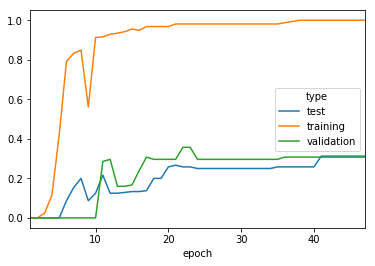

In [157]:
pd.read_json(osp.join(optimizer.output_dir, 'data', 'history.json'))\
    .set_index(['epoch', 'type'])['f1'].unstack().plot()

In [158]:
# Predict with trained model
predict_args = dict(splits_file=optimizer.get_splits_file())
args = dict(cli=optimizer.cli_args(), predict=predict_args)
cmd = optimizer.format(optimizer.client.cmd(**args))
print(cmd)
optimizer.client.execute(cmd)

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=secreted_cytokine --device="cuda:1" --output-dir=/lab/data/results/gridsearch-dev/run2/secreted_cytokine/data --batch-size=512 predict --splits-file=/lab/data/results/gridsearch-dev/run2/secreted_cytokine/splits/splits.json > /lab/data/results/gridsearch-dev/run2/secreted_cytokine/log/log.txt 2>&1


0

In [159]:
from tcre import visualization
import imp
imp.reload(visualization)

df_pred = pd.read_json(osp.join(optimizer.output_dir, 'data', 'predictions.json')).set_index('id')
pred_cands = session.query(Candidate).filter(Candidate.type == debug_task).all()
pred_cands = [c for c in pred_cands if c.id in df_pred.index]
assert len(pred_cands) == len(df_pred)
df_pred = pd.merge(df_pred.reset_index(), visualization.candidate_df(pred_cands), on='id', how='inner')
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 8 columns):
id        98 non-null int64
y_true    98 non-null int64
y_pred    98 non-null float64
type      98 non-null object
split     98 non-null int64
e1        98 non-null object
e2        98 non-null object
text      98 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 6.9+ KB


In [160]:
df_pred['y_true'].unique(), (df_pred['y_true'] > .5).value_counts()

(array([0, 1]), False    79
 True     19
 Name: y_true, dtype: int64)

In [161]:
(df_pred['y_pred'] > .5).value_counts()

False    89
True      9
Name: y_pred, dtype: int64

In [162]:
from IPython.display import HTML
pd.set_option('display.max_colwidth', 600)
#HTML(df_pred.sort_values('y_pred', ascending=False).head(25).to_html(escape=False))
HTML(df_pred[df_pred['y_true'] == 1].sort_values('y_pred', ascending=False).head(25).to_html(escape=False))
#HTML(df_pred[df_pred['y_pred'] > .5].sort_values('y_pred', ascending=False).head(25).to_html(escape=False))

,id,y_true,y_pred,type,split,e1,e2,text
60,291424,1,0.995636,secreted_cytokine,4,IFN-γ,γδT,We next sought to determine if the production of IFN-γ by CD161 + γδT cells in response to TCR - independent cytokine stimulation occurred in both the Vδ1 + and Vδ2 + γδT cell subsets .
73,364562,1,0.990747,secreted_cytokine,4,IL-23,Th17,"Th17 cells express the IL-23 receptor ( IL-23R ) , and the exquisite pathogenicity of Th17 cells may be associated with their capacity to respond to IL-23 (; ; ; ) . \n"
80,333888,1,0.981965,secreted_cytokine,4,IL-4,Th2,"For example , the cytokines typically produced by Th2 cells , including IL-4 , IL-5 and IL-13 , are silenced in Th1 cells through histone modification [ ] ."
55,288940,1,0.634935,secreted_cytokine,4,TNF-α,Th1,"Supporting this hypothesis , we also found that TNF-α , a cytokine , which can be produced by Th17 and Th1 cells , neither influenced the CD44 level of IL-17 + nor IFN-γ+CD4 + T cells ."
94,298139,1,0.527107,secreted_cytokine,4,IL-4,Th2,"Th2 cells express IL-4 , IL-5 , and IL-13 , which stimulates mucosal immunity against parasite infections ( – ) ."
90,327843,1,0.200419,secreted_cytokine,4,IL-21,Th17,"Another subset that has become increasingly important is Th17 cells that produce a variety of cytokines including IL-17A , IL-21 and IL-22 ."
10,58853,1,0.192096,secreted_cytokine,4,IFN-γ,NKT,"Based on the expression of an invariant TCRα chain ( Vα14-Jα18 in mice , Vα24-Jα18 in humans ) , CD1d - dependent NKT cells can be classified into type I and type II NKT cells , both of which can produce IFN-γ , the Th1 cytokine , and IL-4 , a Th2 cytokine , and participate in the regulation of innate and adaptive immunity ."
9,365585,1,0.147616,secreted_cytokine,4,IL-17,Th17,"The signaling cascade of IL-17 , the signature cytokine of Th17 cells , requires a key signaling molecule , Act1 ( also known as TRAF3IP2 or CIKS ) to propagate downstream signaling events in tissue cells , including activation of the transcription factor NF-κB. The absence of Act1 leads to resistance to IL-17-mediated inflammation in mouse models of experimental autoimmune encephalomyelitis ( EAE ) and asthma ."
61,347530,1,0.131577,secreted_cytokine,4,IL-13,Th2,"Dominance of Th2 responses ( – ) and Th2 cytokines IL-4 ( – ) , IL-10 ( ) , and IL-13 ( ) , can protect against autoimmunity , but their effects are variable . Th2"
66,323721,1,0.126618,secreted_cytokine,4,IL-10,TH17,"a Quantitative RT - PCR analysis of gene expression in human IL-10– and IL-10 + TH17 clones isolated from healthy donors ( two tailed , paired Student ’s t test , mean ± s.d ."
